In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import pymc.sampling_jax
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, precision_score, recall_score, roc_auc_score, accuracy_score, auc
from sklearn.calibration import CalibrationDisplay
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
import os

os.chdir("D:/Programming/project1/Transmission_probability/method1_Binomiale/v_PyMC/")

In [5]:
# Load data 
sero = pd.read_excel("Input/sero_data_binomiale.xlsx")
y = sero["Positive"].to_numpy()  
n = sero["n"].to_numpy()
t = sero["Time"].to_numpy()

In [6]:
%%time
with pm.Model() as model:

    # Prior
    p = pm.Uniform("p", lower=.0001, upper=.01)
    
    p_tot = 1 - (1 - p)**t
    
    y = pm.Binomial("y", n=n, p=p_tot, observed=y) 

CPU times: total: 0 ns
Wall time: 32.9 ms


In [7]:
%%time
with model:
    trace = pm.sampling.jax.sample_blackjax_nuts(draws=10000, tune=1000, chains=10, target_accept=0.95)

Compiling...
Compilation time = 0:00:13.748621
Sampling...
Sampling time = 0:00:03.650953
Transforming variables...
Transformation time = 0:00:00.120962


CPU times: total: 7.25 s
Wall time: 17.8 s


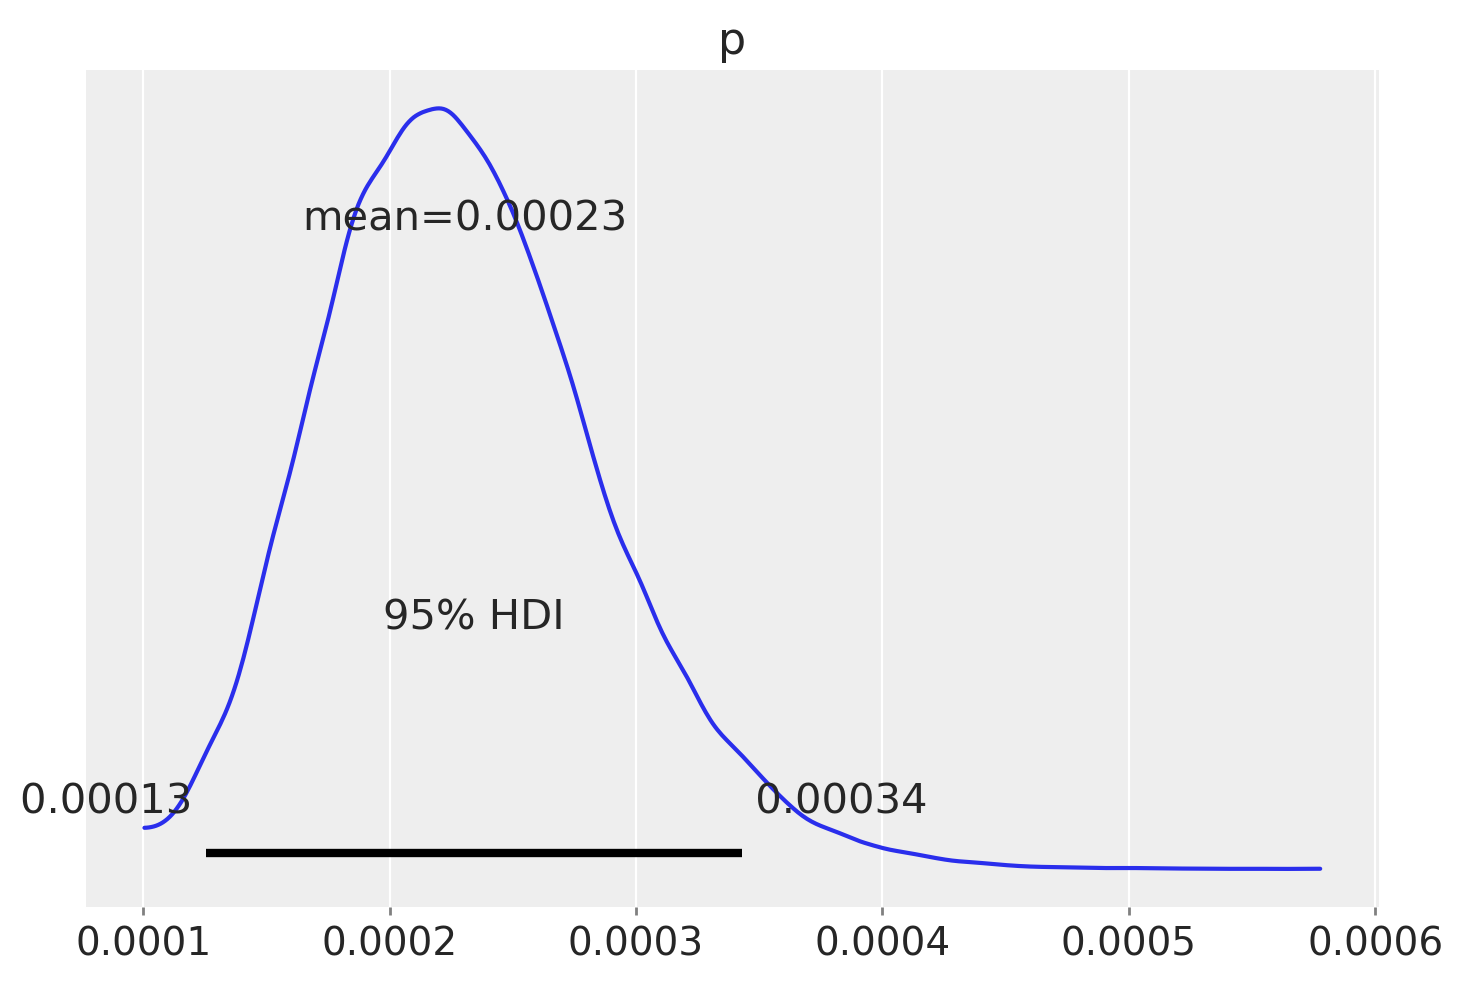

In [8]:
az.plot_posterior(trace, hdi_prob=.95);

# Posterior analysis

In [12]:
az.summary(trace, round_to=5, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.00023,0.00006,0.00013,0.00034,0.0,0.0,21533.75454,17821.40635,1.00061


# Model log-likelihood

In [15]:
with model:
    pm.compute_log_likelihood(trace)

In [16]:
model_loo = az.loo(trace)

model_loo

c:\Users\manhi\anaconda3\envs\tf\lib\site-packages\arviz\stats\stats.py:1040: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Computed from 100000 posterior samples and 11 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -15.63     2.46
p_loo        1.35        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       11  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [17]:
model_waic = az.waic(trace)

model_waic

Computed from 100000 posterior samples and 11 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -15.62     2.46
p_waic        1.34        -

In [18]:
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=42)

Sampling: [y]


c:\Users\manhi\anaconda3\envs\tf\lib\site-packages\arviz\plots\ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
c:\Users\manhi\anaconda3\envs\tf\lib\site-packages\arviz\plots\ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


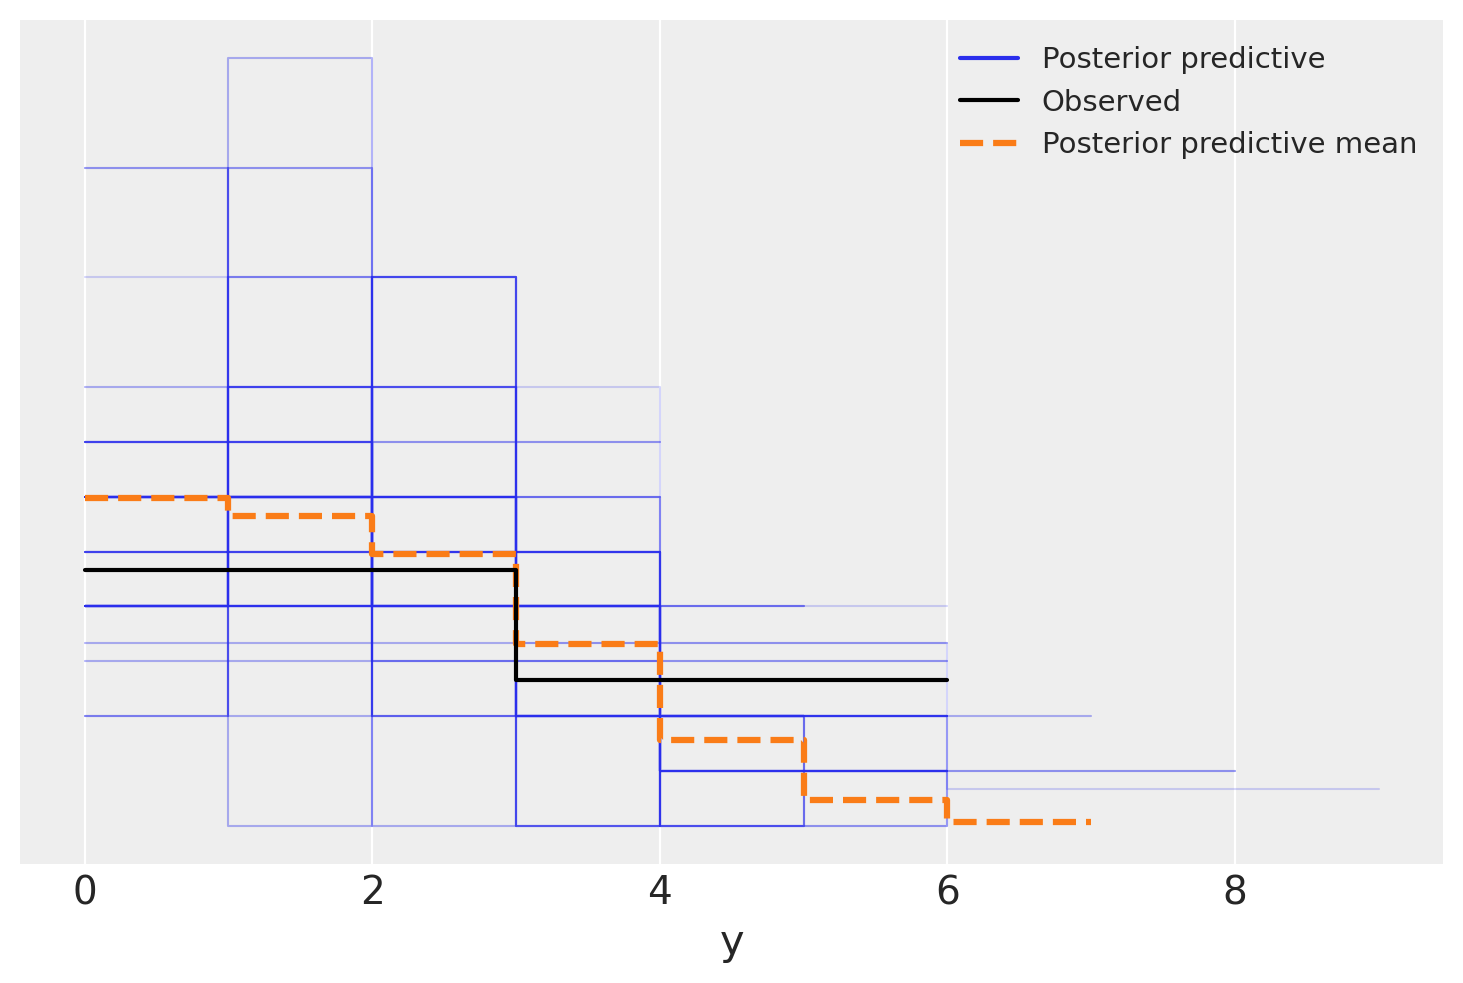

In [19]:
az.plot_ppc(trace, num_pp_samples=100, kind ='kde', observed_rug=True);

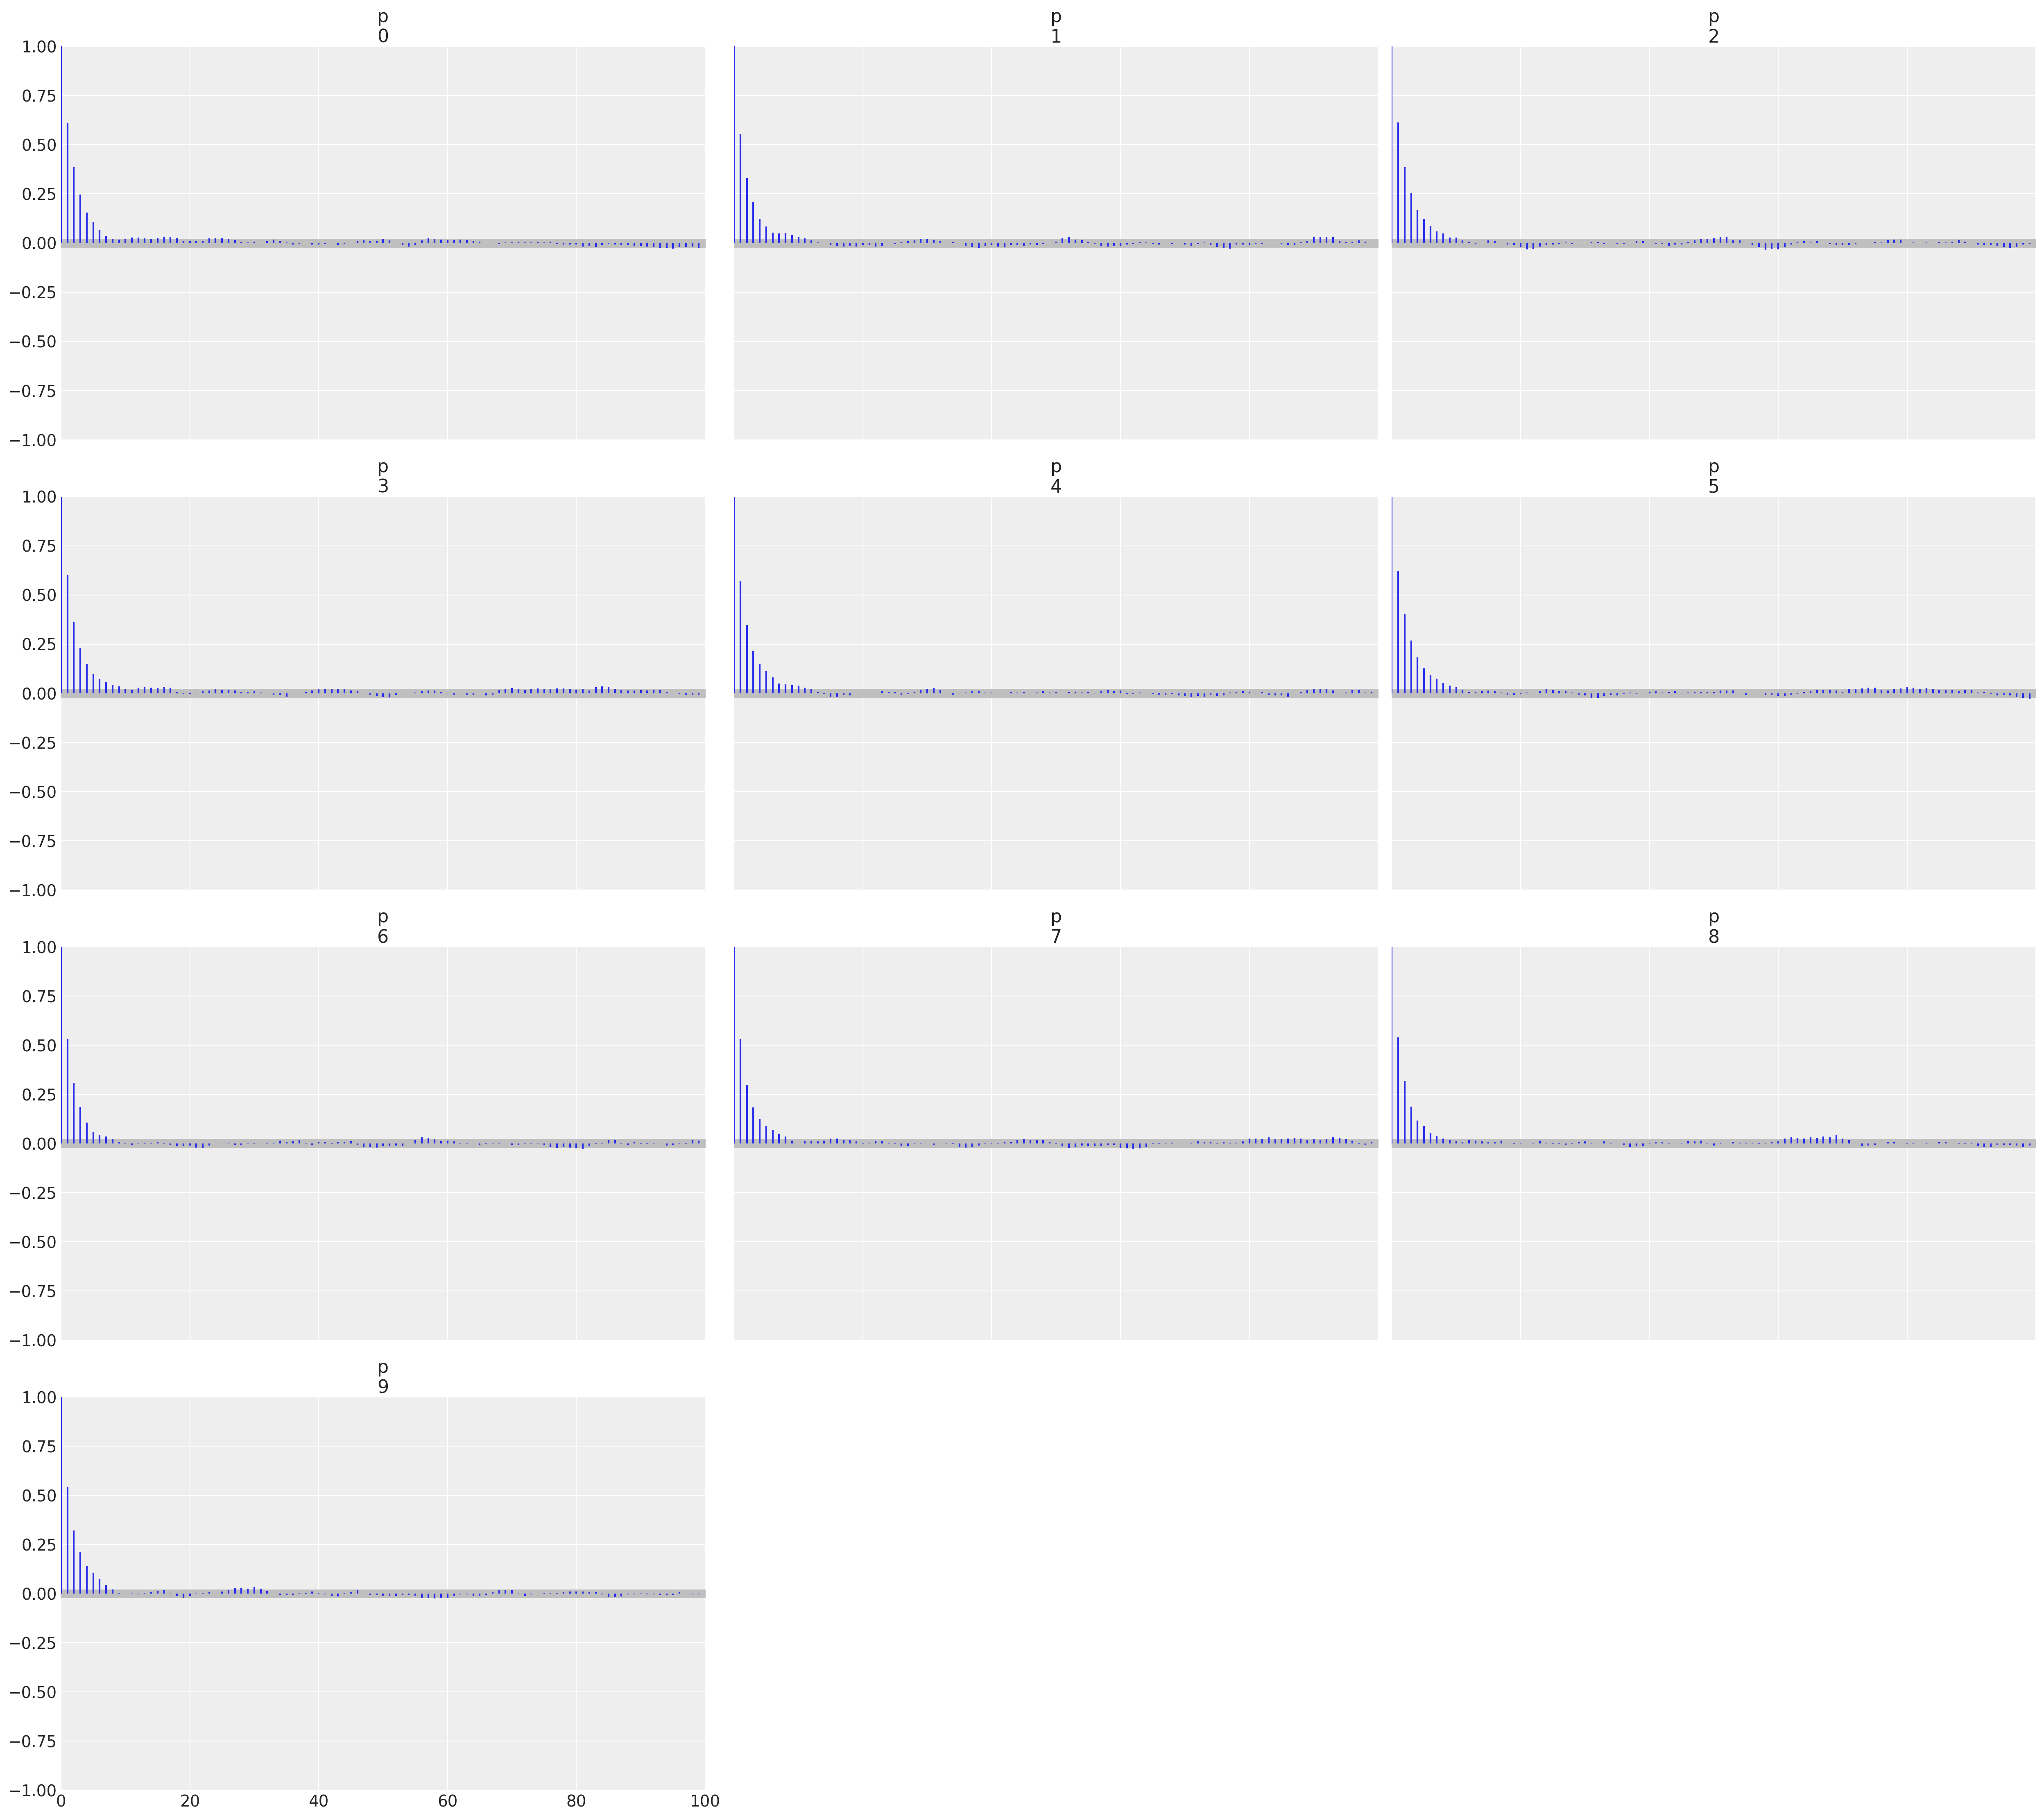

In [20]:
az.plot_autocorr(trace, var_names="p");

In [21]:
# Gelman-Rubin convergence diagnostic
r_hat = az.rhat(trace, var_names=["p"])
print(r_hat)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    p        float64 1.001


In [22]:
ess = az.ess(trace, var_names=["p"])
ess

<xarray.Dataset>
Dimensions:  ()
Data variables:
    p        float64 2.153e+04

c:\Users\manhi\anaconda3\envs\tf\lib\site-packages\arviz\plots\essplot.py:205: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_draws = data.dims["draw"]
c:\Users\manhi\anaconda3\envs\tf\lib\site-packages\arviz\plots\essplot.py:206: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_samples = n_draws * data.dims["chain"]


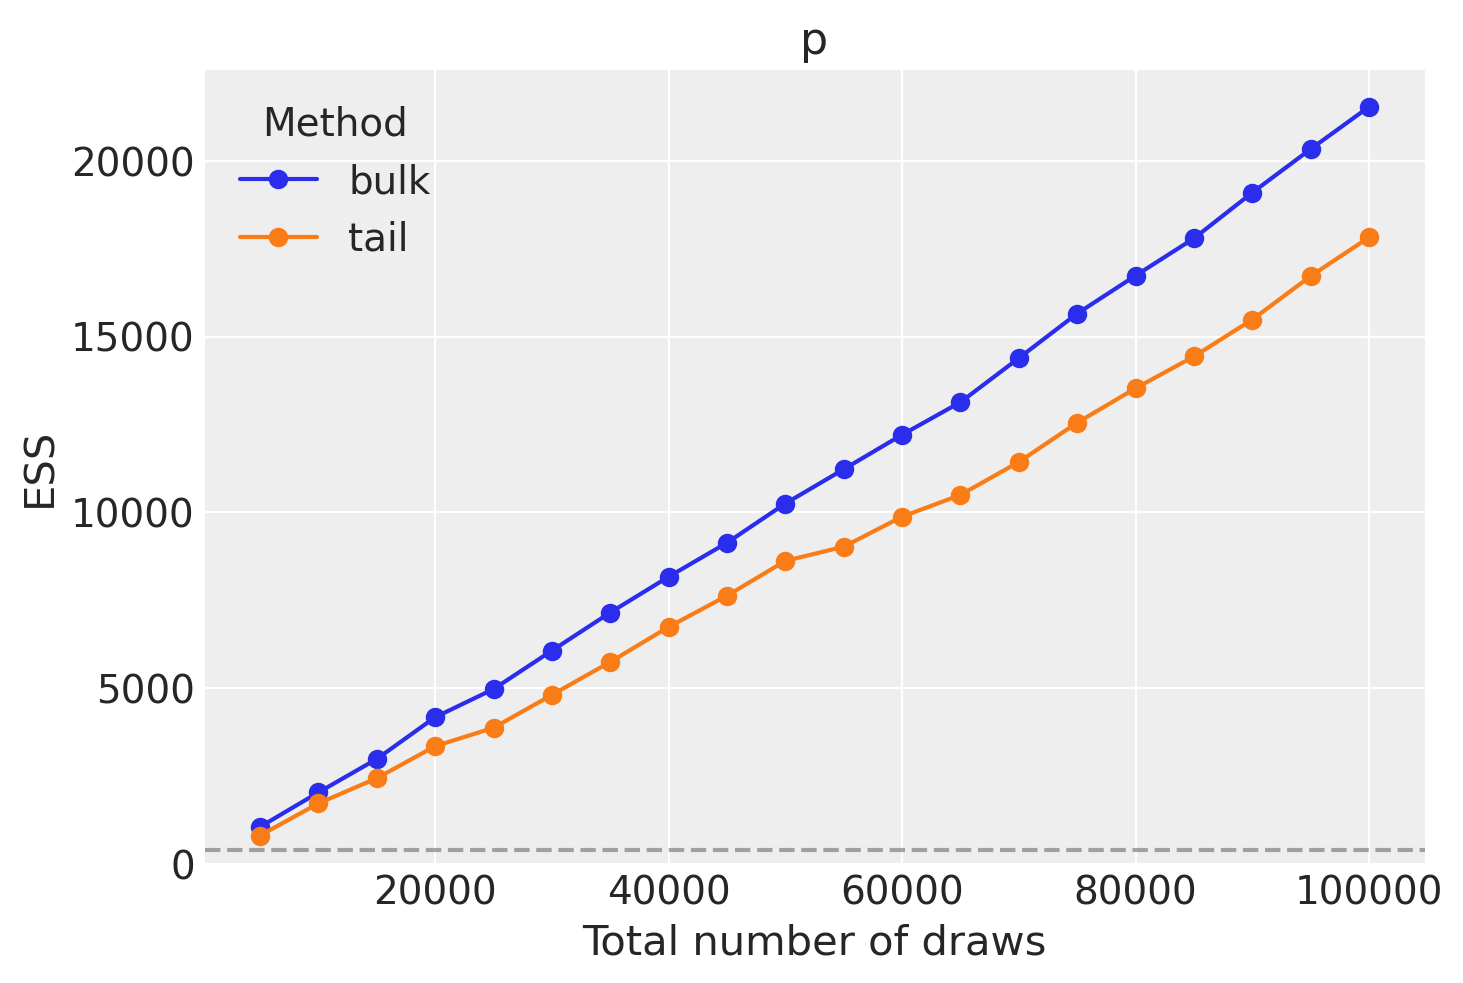

In [23]:
az.plot_ess(trace, var_names=["p"], kind="evolution");

In [24]:
total_ess = ess["p"].sum().values
print(f"Total effective sample size: {float(total_ess):.2f}")

Total effective sample size: 21533.75


In [25]:
p_sample = trace.posterior["p"].stack(sample=("chain", "draw")).values
p_sample = np.random.choice(p_sample, size=1000)

In [26]:
N = sero.shape[0] 
M = len(p_sample)

t = sero["Time"].values
n = sero["n"].values.astype(np.int32)

In [27]:
resultats_simules = np.zeros((N, M)) 

for i in range(M):
    p_i = p_sample[i]
    p_tot = 1 - (1 - p_i)**t
    
    sim = np.random.binomial(n, p_tot)
    resultats_simules[:, i] = sim

df = pd.DataFrame(resultats_simules, 
                  columns=[f"Sim_{i}" for i in range(1, M+1)])

In [28]:
# Prepare observed data
datacal = sero[["Event", "n", "Positive"]]  
datacal.columns = ["Exp", "N", "obs"]

# Calculate summary stats
means = resultats_simules.mean(axis=1) 
print(means)

quantiles = np.quantile(resultats_simules, 
                       q=[0.025, 0.25, 0.5, 0.75, 0.975],
                       axis=1)
print(quantiles)

# Create dataframe
res = pd.DataFrame() 
res["Exp"] = datacal["Exp"]
res = pd.concat([res, pd.DataFrame(quantiles.T)], axis=1)
res["Mean"] = means

# Set column names  
res.columns = ["Exp", "CI2.5", "CI25", "Median",
               "CI75", "CI97.5", "Mean"] 

# Set dtypes
cols = res.columns[1:]
res[cols] = res[cols].astype(float)

print(res)

[0.08  0.493 1.656 1.661 2.727 1.349 1.699 2.417 1.692 2.875 0.609]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 2. 1. 1. 2. 1. 2. 0.]
 [0. 0. 2. 2. 3. 1. 2. 2. 2. 3. 0.]
 [0. 1. 2. 2. 4. 2. 2. 3. 2. 4. 1.]
 [1. 2. 4. 4. 5. 3. 4. 5. 4. 5. 2.]]
                        Exp  CI2.5  CI25  Median  CI75  CI97.5   Mean
0         experiment_1_1_1h    0.0   0.0     0.0   0.0     1.0  0.080
1         experiment_1_2_6h    0.0   0.0     0.0   1.0     2.0  0.493
2        experiment_1_3_24h    0.0   1.0     2.0   2.0     4.0  1.656
3        experiment_2_2_24h    0.0   1.0     2.0   2.0     4.0  1.661
4        experiment_2_3_44h    0.0   2.0     3.0   4.0     5.0  2.727
5        experiment_3_2_24h    0.0   1.0     1.0   2.0     3.0  1.349
6        experiment_4_1_24h    0.0   1.0     2.0   2.0     4.0  1.699
7        experiment_4_2_48h    0.0   2.0     2.0   3.0     5.0  2.417
8        experiment_5_1_24h    0.0   1.0     2.0   2.0     4.0  1.692
9        experiment_5_2_48h    1.0   2.0     3.0   

In [29]:
datacal.loc[:, 'sd'] = np.sqrt(datacal['obs'] * (datacal['N'] - datacal['obs']))

C:\Users\manhi\AppData\Local\Temp\ipykernel_20940\2354775149.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datacal.loc[:, 'sd'] = np.sqrt(datacal['obs'] * (datacal['N'] - datacal['obs']))


In [30]:
datacal

,Exp,N,obs,sd
0,experiment_1_1_1h,6,0,0.000000
1,experiment_1_2_6h,6,0,0.000000
2,experiment_1_3_24h,6,0,0.000000
3,experiment_2_2_24h,6,1,2.236068
4,experiment_2_3_44h,6,4,2.828427
5,experiment_3_2_24h,5,3,2.449490
6,experiment_4_1_24h,6,0,0.000000
7,experiment_4_2_48h,5,4,2.000000
8,experiment_5_1_24h,6,1,2.236068
9,experiment_5_2_48h,6,3,3.000000


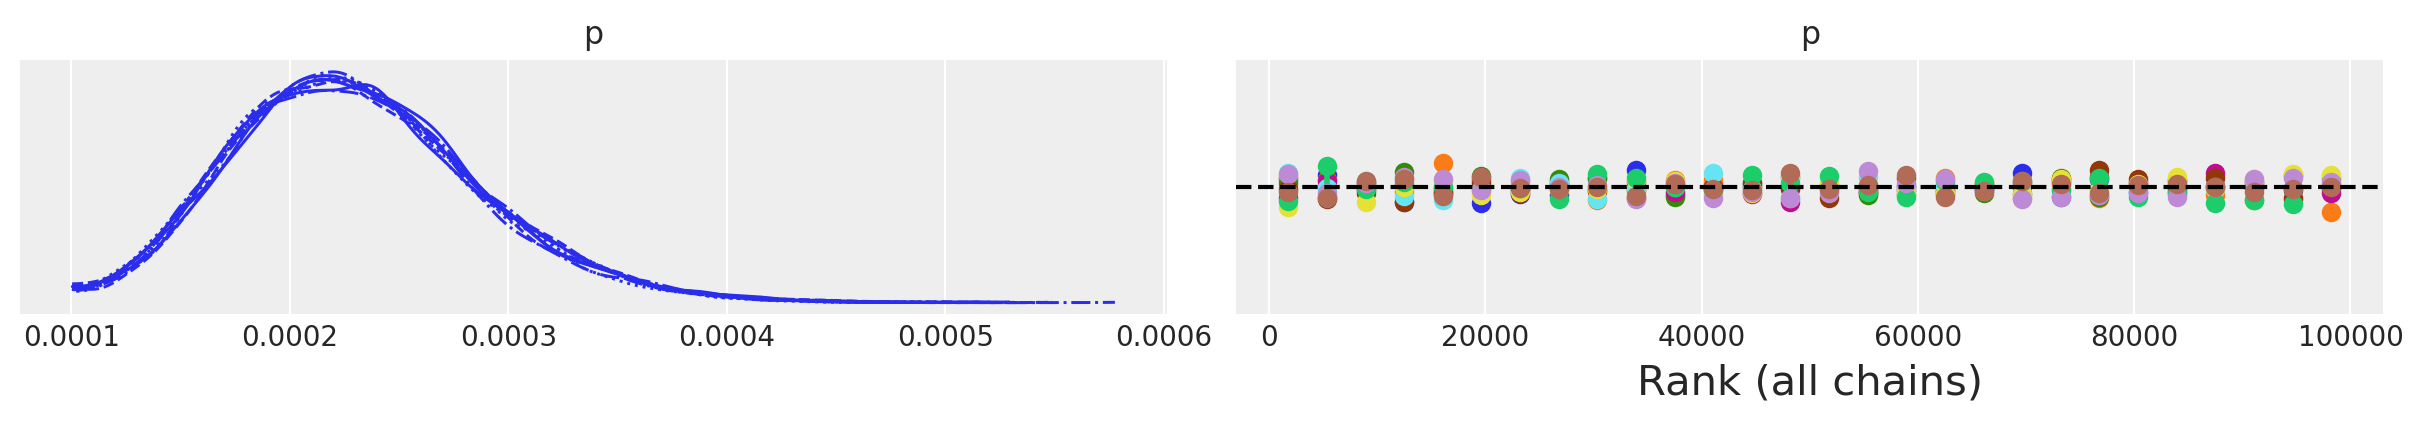

In [31]:
az.plot_trace(trace, var_names="p", kind="rank_vlines");


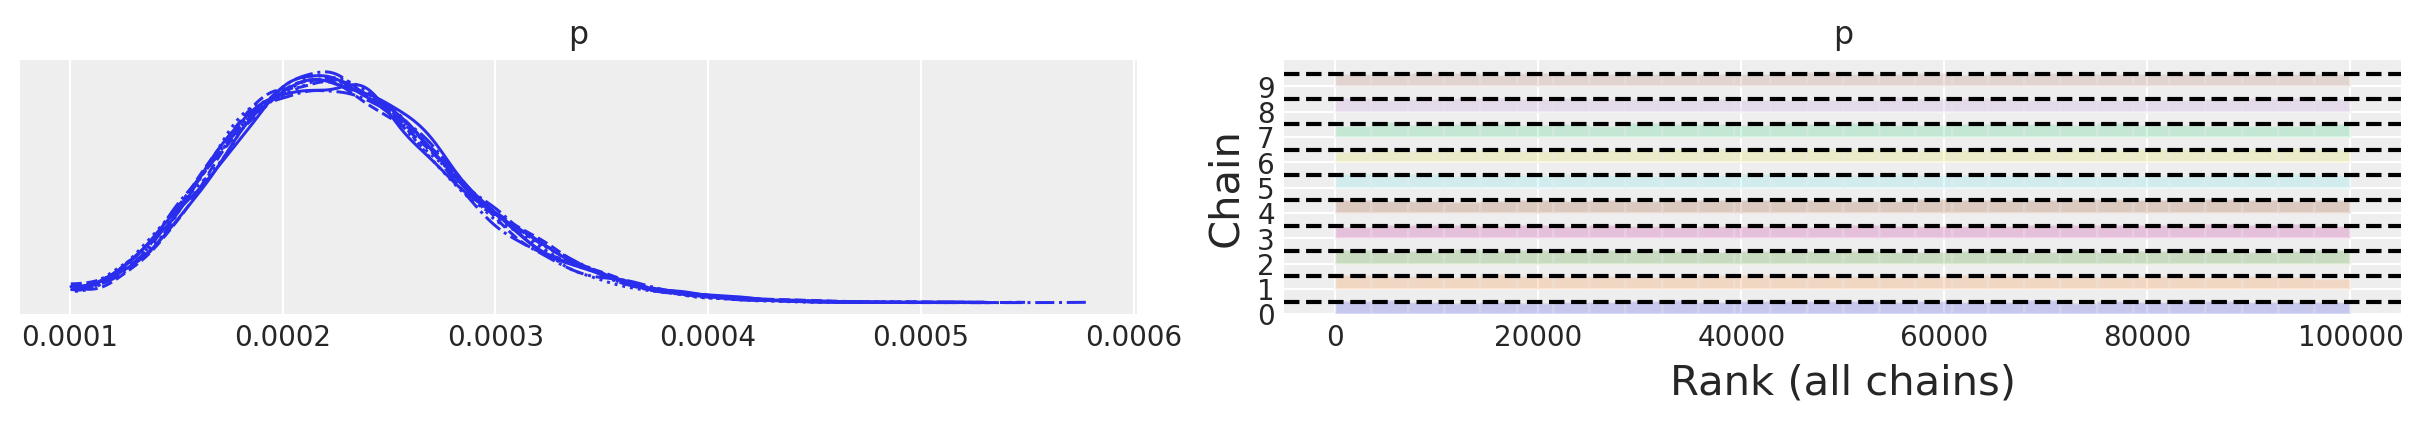

In [32]:
az.plot_trace(trace, var_names="p", kind="rank_bars");


<Axes: title={'center': 'p'}, xlabel='Quantile', ylabel='MCSE for quantiles'>

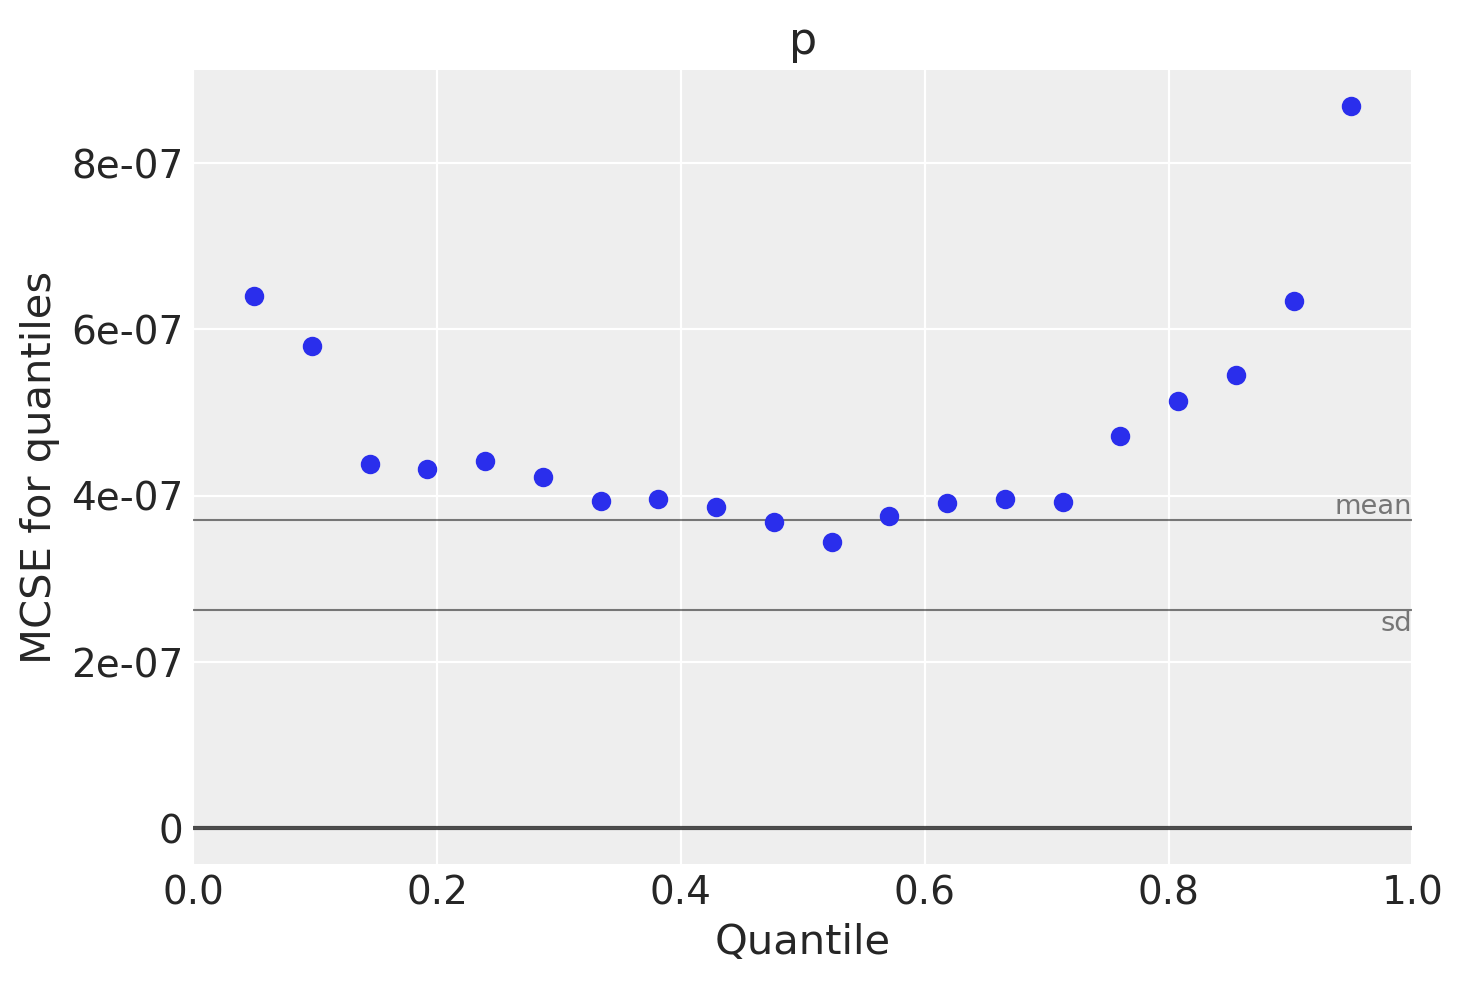

In [33]:
az.plot_mcse(trace, var_names=["p"], rug=True, extra_methods=True)

c:\Users\manhi\anaconda3\envs\tf\lib\site-packages\arviz\stats\stats.py:1040: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


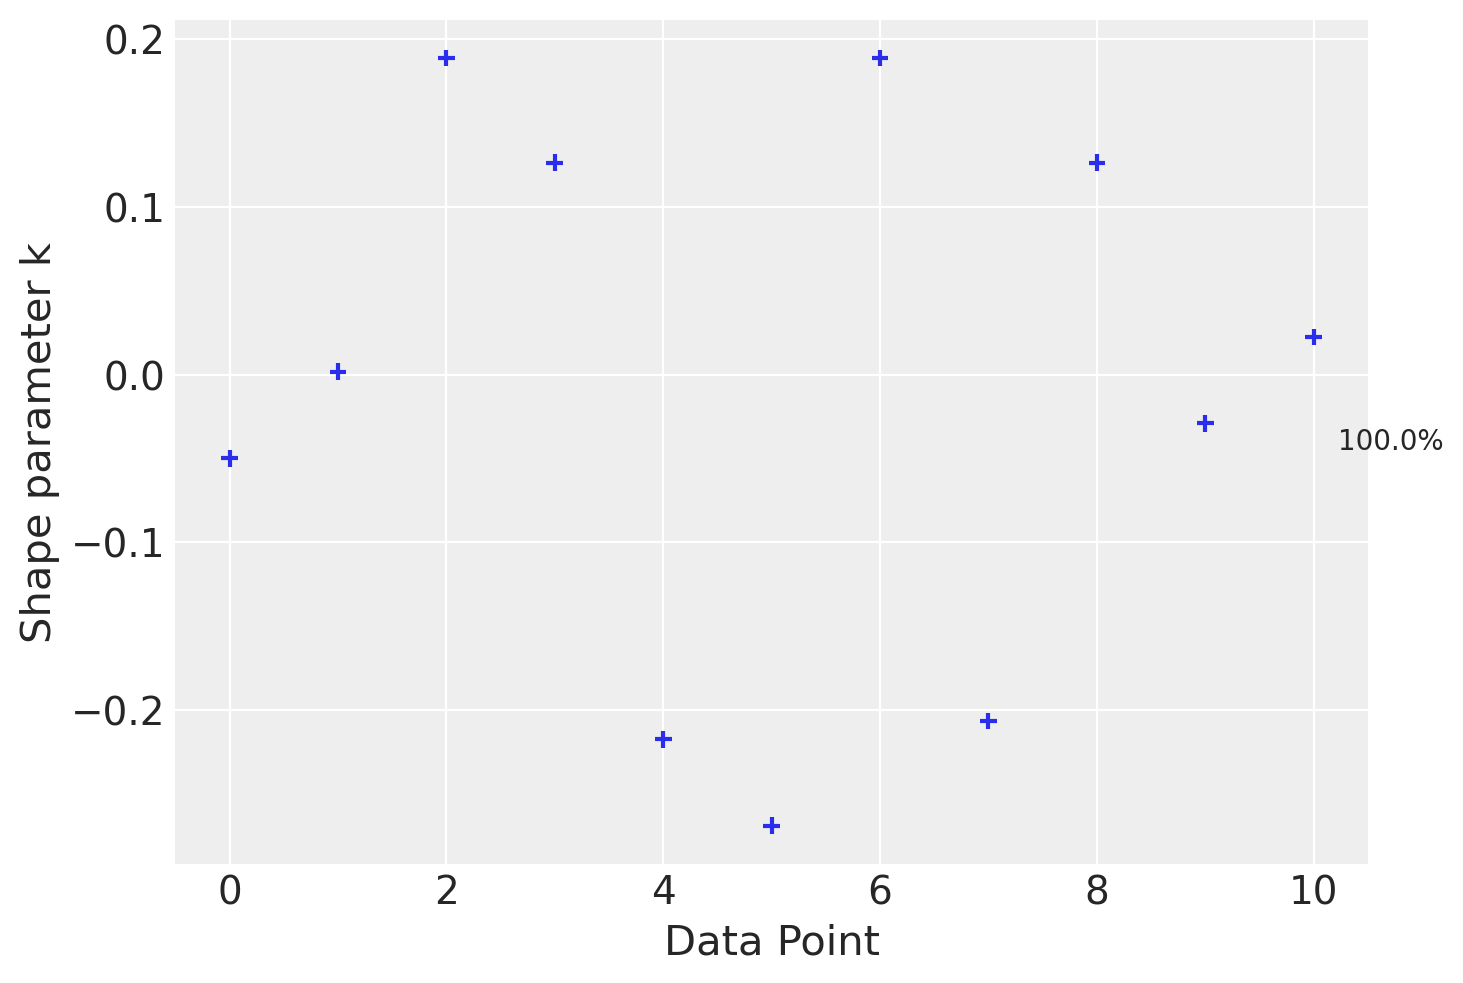

In [34]:
loo = az.loo(trace, pointwise=True)

az.plot_khat(loo, show_bins=True);


In [ ]:
az.plot_loo_pit(trace, y="y", ecdf=True)

In [35]:
import seaborn as sns

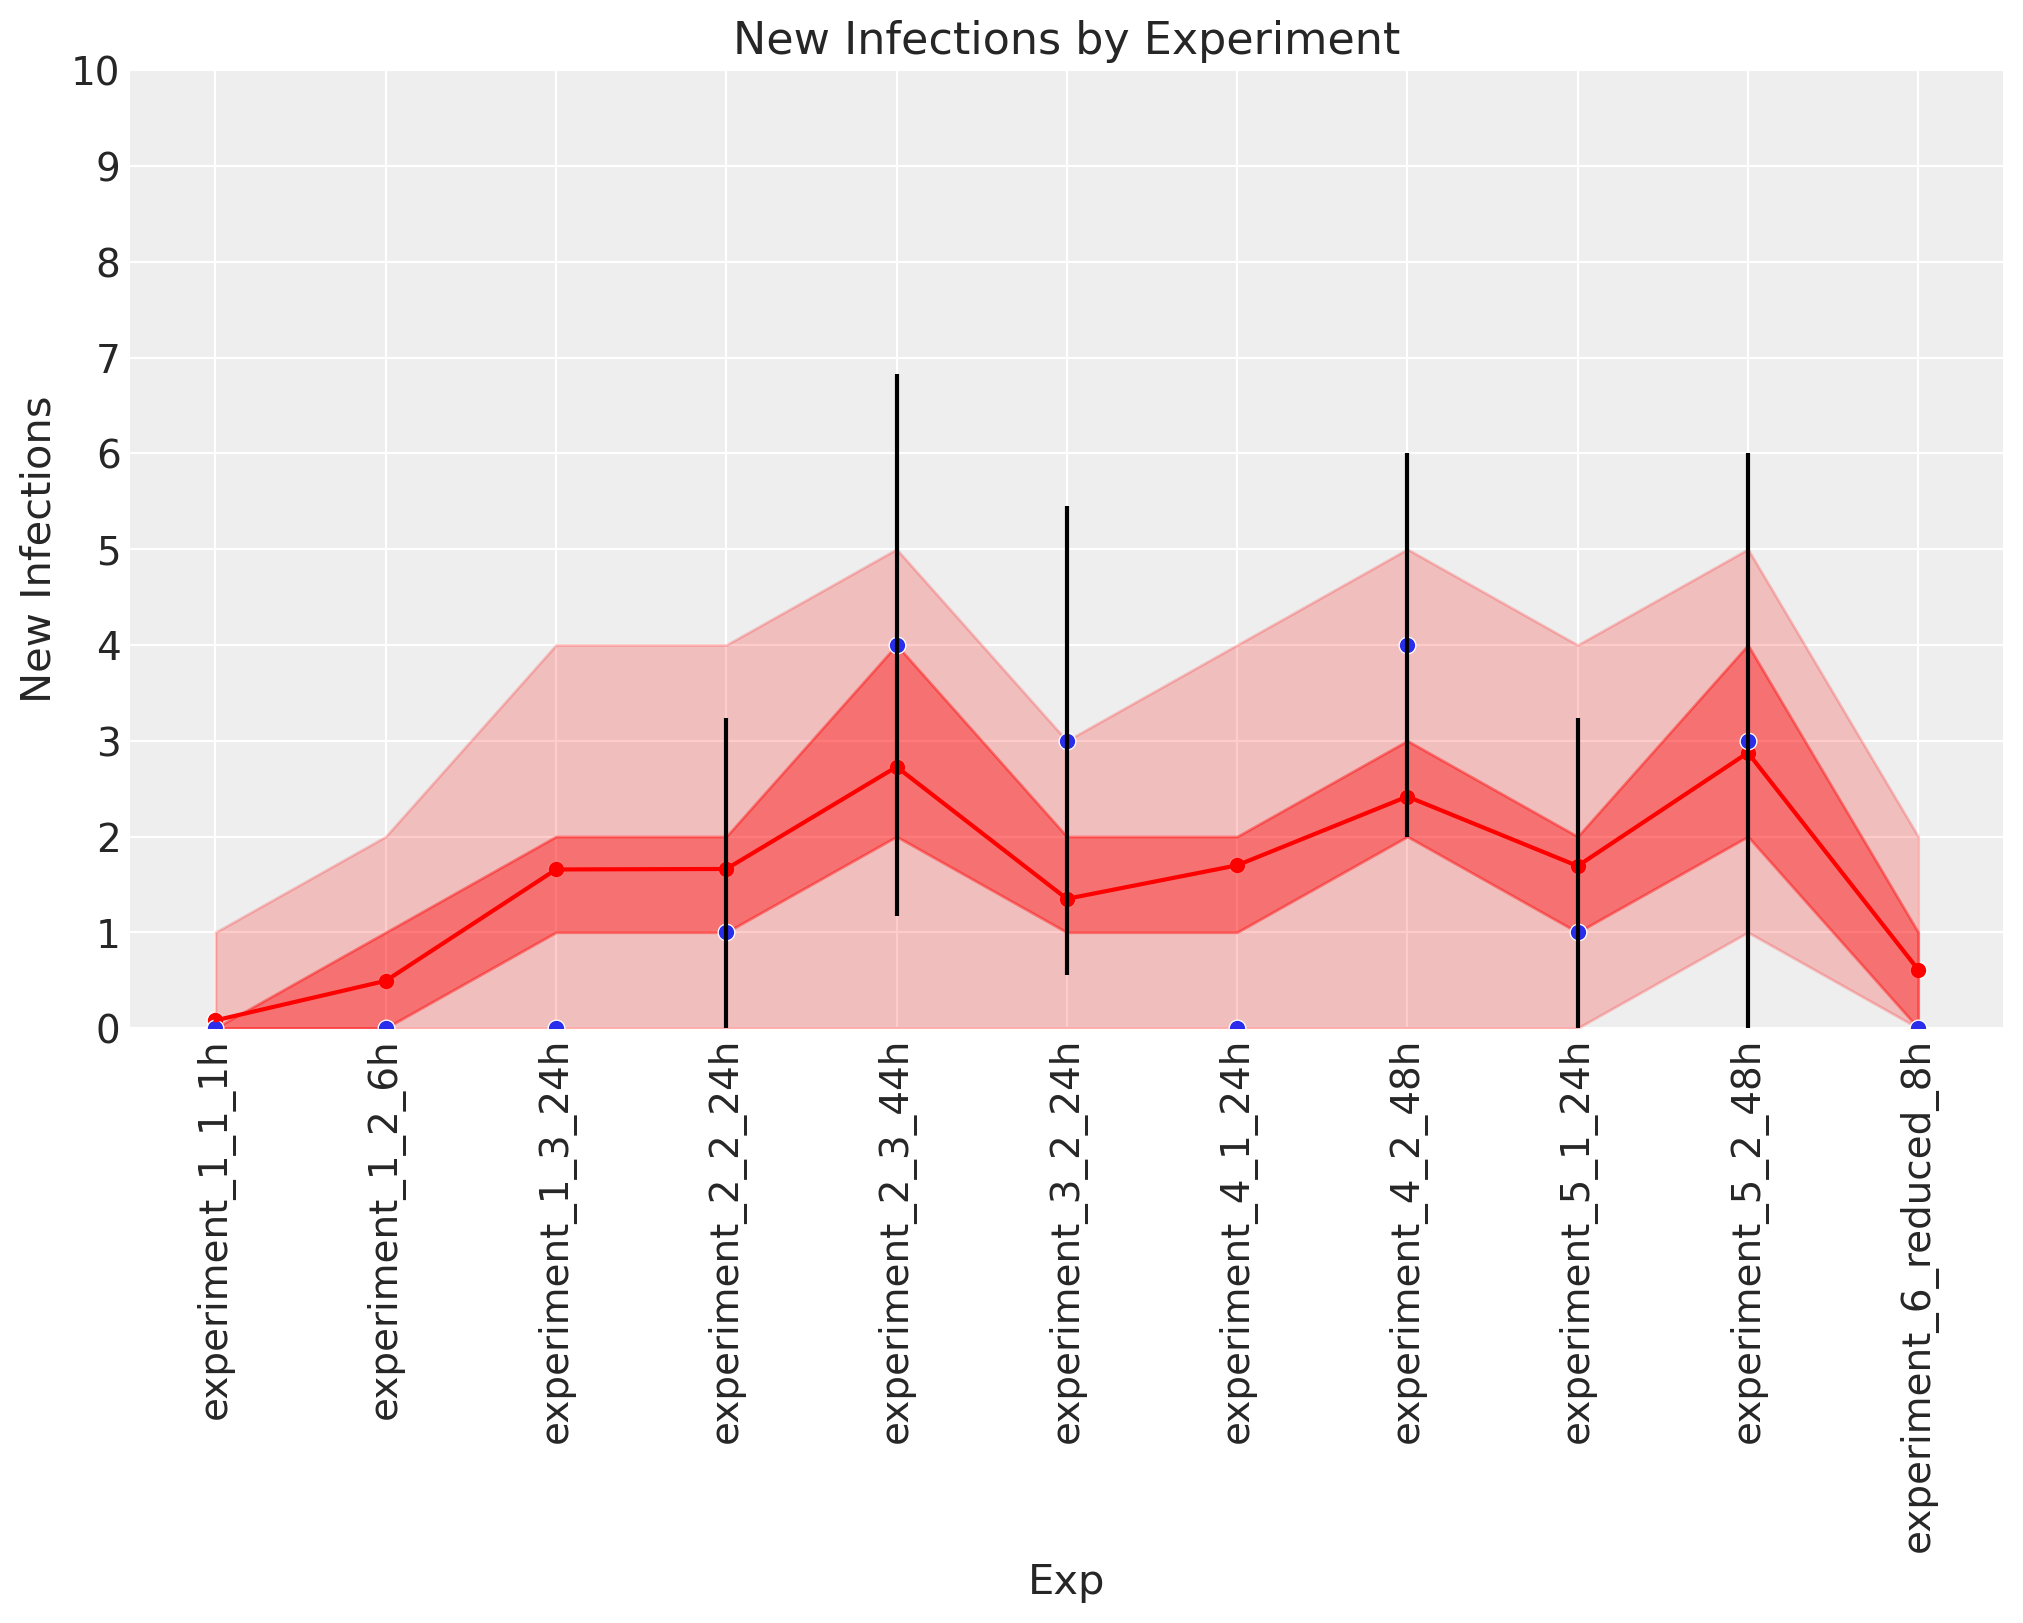

In [36]:
# Plotting the main line and points
plt.figure(figsize=(10, 8))
sns.lineplot(data=res, x='Exp', y='Mean', color='red')
sns.scatterplot(data=res, x='Exp', y='Mean', color='red')

# Adding confidence intervals (ribbons)
plt.fill_between(res['Exp'], res['CI2.5'], res['CI97.5'], color='red', alpha=0.2)
plt.fill_between(res['Exp'], res['CI25'], res['CI75'], color='red', alpha=0.4)

# Adding points and error bars from 'datacal'
sns.scatterplot(data=datacal, x='Exp', y='obs')
plt.errorbar(datacal['Exp'], datacal['obs'], yerr=datacal['sd'], fmt='none', ecolor='black')

# Setting labels and title
plt.title("New Infections by Experiment")
plt.xlabel("Exp")
plt.ylabel("New Infections")

# Setting y-limits and y-ticks
plt.ylim(0, 10)
plt.yticks(np.arange(0, 11, 1))

# Rotating x-axis labels
plt.xticks(rotation=90)

# Hiding the legend
plt.legend([],[], frameon=False)

plt.show()


In [ ]:
import pickle

In [ ]:
with open('trace_binomiale.pkl', 'wb') as f:
    pickle.dump(trace, f)